In [1]:
import os, sys
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
np.seterr(divide='ignore', invalid='ignore')

from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - np.nan_to_num(num.view()/den.view(), False, 1))

In [25]:
! ls ../python/Nov11_2017/stacked_hists/ele_hists.pkl

cut_values_ele.pkl  ele_hists	   ele_hists.pkl  mu_hists_log
cut_values_mu.pkl   ele_hists_log  mu_hists	  mu_hists.pkl


In [74]:
# you can load the output!
import pickle
with open('../python/Nov11_2017/miso_hists/ele_hists.pkl', 'rb') as f:
    hists = pickle.load(f)

In [95]:
for cut in hists.keys():
    compute_soverb(hists[cut], cut, 'ele', range_min = 0, range_max = 150, remove_ttH = True)

Cut lep_miso<0.1: S/sqrt(B) in range [0, 150] of (Jet-Lep).mass is: 0.19
Cut lep_miso<0.3: S/sqrt(B) in range [0, 150] of (Jet-Lep).mass is: 0.19
Cut lep_miso<0.5: S/sqrt(B) in range [0, 150] of (Jet-Lep).mass is: 0.19
Cut lep_miso<0.7: S/sqrt(B) in range [0, 150] of (Jet-Lep).mass is: 0.19
Cut lep_miso<0.9: S/sqrt(B) in range [0, 150] of (Jet-Lep).mass is: 0.19
Cut lep_miso<1.1: S/sqrt(B) in range [0, 150] of (Jet-Lep).mass is: 0.19
Cut lep_miso<1.3: S/sqrt(B) in range [0, 150] of (Jet-Lep).mass is: 0.19
Cut lep_miso<1.5: S/sqrt(B) in range [0, 150] of (Jet-Lep).mass is: 0.19


In [96]:
hists[0.1]

Hist(
  StrCategory(['SingleElectron', 'DYJets', 'QCD', 'ttHToNonbb_M125', 'VH', 'GluGluHToWW_Pt-200ToInf_M-125', 'VBFHToWWToLNuQQ_M-125_withDipoleRecoil', 'TTbar', 'SingleTop', 'WJetsLNu', 'WZQQ', 'Diboson'], growth=True, name='samples', label='samples'),
  Regular(35, 0, 280, name='lep_fj_m', label='Jet - Lepton mass [GeV]'),
  storage=Double()) # Sum: 507212.3239609954 (509511.0527281836 with flow)

In [84]:
hists[0.5][{"samples": "GluGluHToWW_Pt-200ToInf_M-125"}]

Hist(Regular(35, 0, 280, name='lep_fj_m', label='Jet - Lepton mass [GeV]'), storage=Double()) # Sum: 72.81195604117812 (72.86704549244051 with flow)

In [87]:
hists[1.5][{"samples": "GluGluHToWW_Pt-200ToInf_M-125"}]

Hist(Regular(35, 0, 280, name='lep_fj_m', label='Jet - Lepton mass [GeV]'), storage=Double()) # Sum: 73.20174326640343 (73.26462045048042 with flow)

In [93]:
! pwd

/uscms/home/fmokhtar/nobackup/boostedhiggs/binder


In [94]:
def compute_soverb(h, cut, ch, range_min = 0, range_max = 150, remove_ttH = True):
    
    data_label = data_by_ch
    signal_by_ch = {
    'ele': ['ttHToNonbb_M125', 'GluGluHToWW_Pt-200ToInf_M-125', 'VH', 'VBFHToWWToLNuQQ_M-125_withDipoleRecoil'],
    'mu': ['ttHToNonbb_M125', 'GluGluHToWW_Pt-200ToInf_M-125', 'VH', 'VBFHToWWToLNuQQ_M-125_withDipoleRecoil'],
    }

    # get samples existing in histogram
    samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
    signal_labels = [label for label in samples if label in signal_by_ch[ch]]
    bkg_labels = [label for label in samples if (label and label != data_label and label not in signal_labels)]
    
    if remove_ttH:
        signal_labels.remove("ttHToNonbb_M125")

    # data
    data = None
    if data_label in h.axes[0]:
        data = h[{"samples": data_label}]

    # signal
    signal = [h[{"samples": label}] for label in signal_labels]
    # sum all of the signal
    if len(signal) > 0:
        tot_signal = None
        for i, sig in enumerate(signal):
            if tot_signal == None:
                tot_signal = signal[i].copy()
            else:
                tot_signal = tot_signal + signal[i]

    totsignal_val = tot_signal.values()

    # background
    bkg = [h[{"samples": label}] for label in bkg_labels]
    # sum all of the background
    if len(bkg) > 0:
        tot = bkg[0].copy()
        for i, b in enumerate(bkg):
            if i > 0:
                tot = tot + b

        tot_val = tot.values()
        tot_val_zero_mask = (tot_val == 0)
        tot_val[tot_val_zero_mask] = 1

    # replace values where bkg is 0
    totsignal_val[tot_val==0] = 0

    # integrate soverb in a given range for lep_fj_m
    bin_array = tot_signal.axes[0].edges[:-1] # remove last element since bins have one extra element
    condition = (bin_array>=range_min) & (bin_array<=range_max)

    s = totsignal_val[condition].sum()
    b = np.sqrt(tot_val[condition].sum())

    soverb_integrated = round((s/b).item(),2)
    print(f"Cut lep_miso<{cut}: S/sqrt(B) in range [{range_min}, {range_max}] of (Jet-Lep).mass is: {soverb_integrated}")
   
    return soverb_integrated

In [101]:
# you can load the output!
import pickle
with open('/eos/uscms/store/user/fmokhtar/boostedhiggs/lumi_2017/lumi_set.pkl', 'rb') as f:
    lumi_set = pickle.load(f)

In [102]:
lumi_set.keys()

dict_keys(['SingleElectron_Run2017B', 'SingleElectron_Run2017D', 'SingleElectron_Run2017F', 'SingleMuon_Run2017C', 'SingleMuon_Run2017E', 'SingleElectron_Run2017C', 'SingleElectron_Run2017E', 'SingleMuon_Run2017B', 'SingleMuon_Run2017D', 'SingleMuon_Run2017F'])

In [103]:
# combine the sets from the different datasets
lumis = {}

for i, dataset in enumerate(lumi_set.keys()):

    if "Muon" in dataset:
        ch = "mu"
    else:
        ch = "ele"
    print(dataset, ch)
    
    if ch not in lumis.keys():
        lumis[ch] = lumi_set[dataset]
    else:
        lumis[ch] = lumis[ch] | lumi_set[dataset]

# convert the set to a numpy 2d-array
for ch in ["ele", "mu"]:
    lumis[ch] = np.array(list(lumis[ch]))

SingleElectron_Run2017B ele
SingleElectron_Run2017D ele
SingleElectron_Run2017F ele
SingleMuon_Run2017C mu
SingleMuon_Run2017E mu
SingleElectron_Run2017C ele
SingleElectron_Run2017E ele
SingleMuon_Run2017B mu
SingleMuon_Run2017D mu
SingleMuon_Run2017F mu


In [104]:
import cloudpickle

from coffea.lumi_tools import LumiData, LumiMask, LumiList
from coffea.util import numpy as np

# make LumiList object
lumi_list = {}
for ch in ["ele", "mu"]:
    lumi_list[ch] = LumiList(runs=lumis[ch][:, 0], lumis=lumis[ch][:, 1])

    # this csv was made using brilcalc and the GoldenJson2017
    # refer to https://github.com/CoffeaTeam/coffea/blob/52e102fce21a3e19f8c079adc649dfdd27c92075/coffea/lumi_tools/lumi_tools.py#L20
    lumidata = LumiData("lumi2017.csv")
    print(ch, lumidata.get_lumi(lumi_list[ch]))
    
    # 41480 is what we are using in the processor for 2017

ele 41476.02229187872
mu 41475.2609652207


# Load outfiles of trigger_efficiency_processor

In [47]:
! ls ../outfiles

0-1.pkl  0-25.pkl


In [48]:
# you can load the output!
import pickle
with open('../outfiles/0-25.pkl', 'rb') as f:
    out = pickle.load(f)

In [49]:
sig = 'GluGluHToWWToLNuQQ'
sig = 'GluGluHToWW_Pt-200ToInf_M-125'

skimmed_events_ele = out["2017"][sig]['skimmed_events']['ele']
skimmed_events_mu = out["2017"][sig]['skimmed_events']['mu']

In [50]:
skimmed_events_ele.keys()

dict_keys(['HLT_ele115', 'weight_id_electron', 'fj_msoftdrop', 'HLT_ele35', 'weight_L1Prefiring', 'lep_pt', 'higgspt', 'weight_genweight', 'weight_pileup', 'fj_pt', 'HLT_Photon200', 'weight_reco_electron', 'weight_trigger_electron'])

In [51]:
skimmed_events_mu.keys()

dict_keys(['weight_trigger_noniso_muon', 'HLT_Mu50', 'weight_id_electron', 'weight_trigger_electron', 'fj_msoftdrop', 'HLT_IsoMu27', 'weight_L1Prefiring', 'HLT_OldMu100', 'weight_reco_electron', 'HLT_TkMu100', 'lep_pt', 'weight_genweight', 'higgspt', 'weight_isolation_muon', 'weight_trigger_iso_muon', 'fj_pt', 'weight_id_muon', 'weight_pileup'])

# Plotting scatter plot

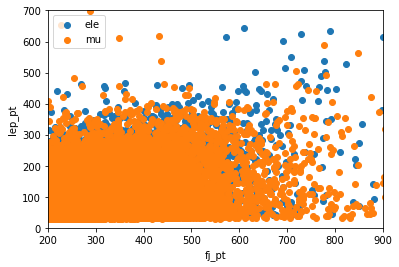

In [52]:
lep_pt = skimmed_events_ele['lep_pt']
fj_pt = skimmed_events_ele['fj_pt']
plt.scatter(fj_pt, lep_pt, label='ele')

lep_pt = skimmed_events_mu['lep_pt']
fj_pt = skimmed_events_mu['fj_pt']
plt.scatter(fj_pt, lep_pt, label='mu')

plt.xlabel('fj_pt')
plt.ylabel('lep_pt');
plt.ylim(0,700)
plt.xlim(200,900)
plt.legend(loc='upper left');

# Plotting trigger efficiency plots

In [54]:
triggers = {}
triggers['mu'] = ['HLT_Mu50', 'HLT_TkMu100', 'HLT_IsoMu27', 'HLT_OldMu100']
triggers['ele'] = ['HLT_ele35', 'HLT_ele115', 'HLT_Photon200']

In [66]:
weight_trigger = skimmed_events_mu["weight_trigger_iso_muon"]
weight_trigger = skimmed_events_ele["weight_trigger_electron"]

# now we can make histograms for higgspt, jetpt, leptonpt
import hist as hist2
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)

hpt_axis = hist2.axis.Regular(10, 100, 700, name='higgspt', label=r'matched H $p_T$ [GeV]')
jetpt_axis = hist2.axis.Regular(10, 200, 500, name='jetpt', label=r'Jet $p_T$ [GeV]')
leppt_axis = hist2.axis.Regular(10, 25, 500, name='leppt', label=r'Lepton $p_T$ [GeV]')

# now we can fill the histogram with the denominator (baseline selection already applied)
hists = hist2.Hist(
                channel_cat,
                region_cat,
                trigger_cat,
                hpt_axis,
                jetpt_axis,
                leppt_axis,
            )
    
channels = ['mu', 'ele']
channels = ['ele']

for ch in channels:
    
    if ch == 'mu':
        skimmed_events = skimmed_events_mu
        weight_trigger = skimmed_events_mu["weight_trigger_iso_muon"]
    else:
        skimmed_events = skimmed_events_ele   
        weight_trigger = skimmed_events_ele["weight_trigger_electron"]

    higgspt = skimmed_events["higgspt"]
    jetpt = skimmed_events["fj_pt"]
    leppt = skimmed_events["lep_pt"]
        
    hists.fill(
        channel=ch,
        region="denominator",
        trigger="all",
        higgspt=higgspt,
        jetpt=jetpt,
        leppt=leppt,
        weight=weight_trigger
    )    
    for trigger in triggers[ch]:
        hists.fill(
            channel=ch,
            region="numerator",
            trigger=trigger,
            higgspt=higgspt[skimmed_events[trigger]],
            jetpt=jetpt[skimmed_events[trigger]],
            leppt=leppt[skimmed_events[trigger]],
            weight=weight_trigger[skimmed_events[trigger]]
        )

In [67]:
hists

Hist(
  StrCategory(['ele'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  StrCategory(['all', 'HLT_ele35', 'HLT_ele115', 'HLT_Photon200'], growth=True, name='trigger', label='trigger'),
  Regular(10, 100, 700, name='higgspt', label='matched H $p_T$ [GeV]'),
  Regular(10, 200, 500, name='jetpt', label='Jet $p_T$ [GeV]'),
  Regular(10, 25, 500, name='leppt', label='Lepton $p_T$ [GeV]'),
  storage=Double()) # Sum: 26127.164024412632 (63845.51708996296 with flow)

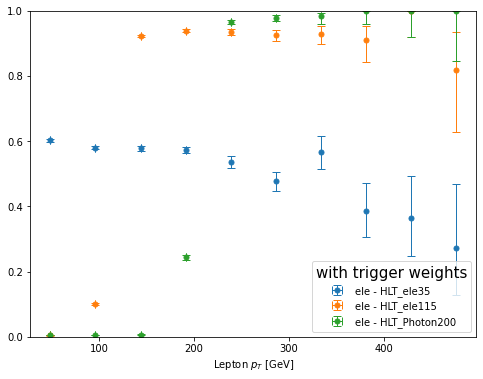

In [70]:
# now we plot trigger efficiency as function of leptonpt
for ch in channels:
    fig, ax = plt.subplots(figsize=(8,6))

    den = hists[{"region":"denominator","channel":ch, "trigger":sum, 'jetpt':sum, 'higgspt':sum}]

    for trigger in triggers[ch]:
        num = hists[{"region":"numerator", "channel":ch,"trigger":trigger, 'jetpt':sum, 'higgspt':sum}]
        hep.histplot(num/den, 
                     yerr = get_yerr(num,den),
                     ax = ax,
                     histtype='errorbar', 
                     capsize=4, 
                     elinewidth=1, 
                     label=f'{ch} - {trigger}'          
        )
    
    ax.set_ylim(0,1)
    ax.legend(title="with trigger weights", title_fontsize=15)
    plt.show()
#     plt.savefig('plots/mu_triggers/leppt.pdf');

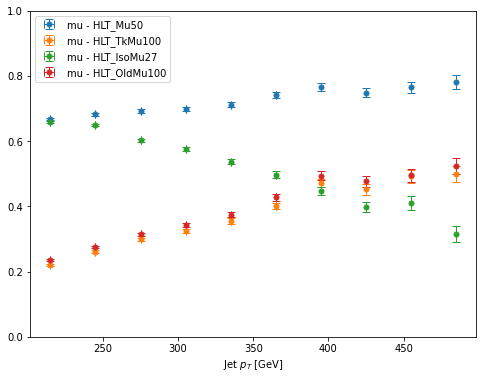

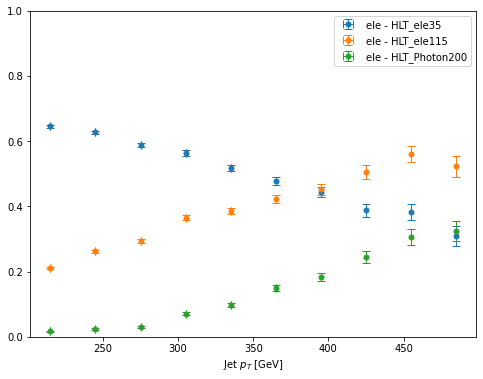

In [26]:
# now we plot trigger efficiency as function of jetpt
for ch in channels:
    fig, ax = plt.subplots(figsize=(8,6))

    den = hists[{"region":"denominator","channel":ch, "trigger":sum, 'leppt':sum, 'higgspt':sum}]

    for trigger in triggers[ch]:
        num = hists[{"region":"numerator", "channel":ch, "trigger":trigger, 'leppt':sum, 'higgspt':sum}]
        
        hep.histplot(num/den, 
                     yerr = get_yerr(num,den),
                     ax = ax,
                     histtype='errorbar', 
                     capsize=4, 
                     elinewidth=1, 
                     label=f'{ch} - {trigger}'          
        )
    ax.set_ylim(0,1)
    ax.legend()
#     plt.savefig('plots/mu_triggers/leppt.pdf');

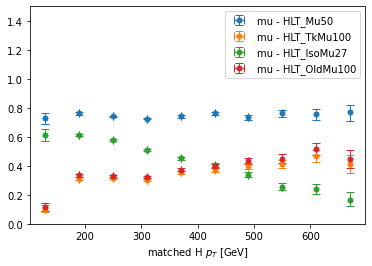

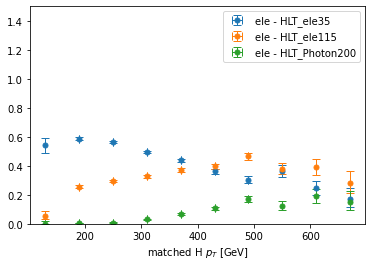

In [19]:
# now we plot trigger efficiency as function of higgspt
for ch in channels:
    fig, ax = plt.subplots(figsize=(6,4))

    den = hists[{"region":"denominator","channel":ch, "trigger":sum, 'jetpt':sum, 'leppt':sum}]

    for trigger in triggers[ch]:
        num = hists[{"region":"numerator", "channel":ch, "trigger":trigger, 'jetpt':sum, 'leppt':sum}]
    
        hep.histplot(num/den, 
                     yerr = get_yerr(num,den),
                     ax = ax,
                     histtype='errorbar', 
                     capsize=4, 
                     elinewidth=1, 
                     label=f'{ch} - {trigger}'          
        )
    ax.set_ylim(0,1.5)
    ax.legend()
#     plt.savefig('plots/mu_triggers/leppt.pdf');

### Plotting: deltaR, HT

In [9]:
# now we can make histograms for deltaR and HT
import hist as hist2
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)

deltaR_axis = hist2.axis.Regular(20, 0, 1.5, name='deltaR', label=r'deltaR')
ht_axis = hist2.axis.Regular(20,180, 1500, name='ht', label=r'HT [GeV]')

hists = {}
hists["jet"] = hist2.Hist(
                channel_cat,
                region_cat,
                trigger_cat,
                deltaR_axis,
                ht_axis,
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
deltaR = skimmed_events_mu["fj_lep_dR"]
ht = skimmed_events_mu["ht"]

hists["jet"].fill(
    channel="mu",
    region="denominator",
    trigger="all",
    deltaR=deltaR,
    ht=ht
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="nominal",
    deltaR=deltaR[skimmed_events_mu["HLT_munominal"]],
    ht=ht[skimmed_events_mu["HLT_munominal"]],

)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="vvl",
    deltaR=deltaR[skimmed_events_mu["HLT_muvvl"]],    
    ht=ht[skimmed_events_mu["HLT_muvvl"]],    
)

hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="met",
    deltaR=deltaR[skimmed_events_mu["HLT_muvvlmet"]],    
    ht=ht[skimmed_events_mu["HLT_muvvlmet"]],    
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="jet",
    deltaR=deltaR[skimmed_events_mu["HLT_jet"]],    
    ht=ht[skimmed_events_mu["HLT_jet"]],    
)

hists["jet"]

Hist(
  StrCategory(['mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  StrCategory(['all', 'nominal', 'vvl', 'met', 'jet'], growth=True, name='trigger', label='trigger'),
  Regular(20, 0, 1.5, name='deltaR', label='deltaR'),
  Regular(20, 180, 1500, name='ht', label='HT [GeV]'),
  storage=Double()) # Sum: 48498.0 (87063.0 with flow)

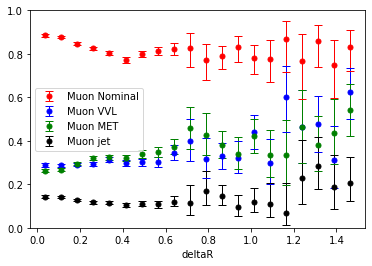

In [10]:
# now we plot trigger efficiency as function of deltaR

num_nom = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal", 'ht':sum}]
num_vvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"vvl", 'ht':sum}]
num_met = hists["jet"][{"region":"numerator","channel":"mu","trigger":"met", 'ht':sum}]
num_jet = hists["jet"][{"region":"numerator","channel":"mu","trigger":"jet", 'ht':sum}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum, 'ht':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nom/den, 
             yerr=get_yerr(num_nom,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal",         
)
hep.histplot(num_vvl/den, 
             yerr=get_yerr(num_vvl,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon VVL",         
)
hep.histplot(num_met/den, 
             yerr=get_yerr(num_met,den),
             ax = ax,
             histtype='errorbar', color='green', capsize=4, elinewidth=1, label="Muon MET",         
)
hep.histplot(num_jet/den, 
             yerr=get_yerr(num_jet,den),
             ax = ax,
             histtype='errorbar', color='black', capsize=4, elinewidth=1, label="Muon jet",         
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/deltaR.pdf');

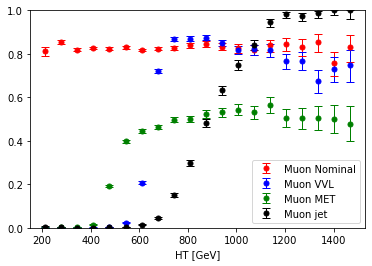

In [11]:
# now we plot trigger efficiency as function of ht
num_nom = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal", 'deltaR':sum}]
num_vvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"vvl", 'deltaR':sum}]
num_met = hists["jet"][{"region":"numerator","channel":"mu","trigger":"met", 'deltaR':sum}]
num_jet = hists["jet"][{"region":"numerator","channel":"mu","trigger":"jet", 'deltaR':sum}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum, 'deltaR':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nom/den, 
             yerr=get_yerr(num_nom,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal",         
)
hep.histplot(num_vvl/den, 
             yerr=get_yerr(num_vvl,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon VVL",         
)
hep.histplot(num_met/den, 
             yerr=get_yerr(num_met,den),
             ax = ax,
             histtype='errorbar', color='green', capsize=4, elinewidth=1, label="Muon MET",         
)
hep.histplot(num_jet/den, 
             yerr=get_yerr(num_jet,den),
             ax = ax,
             histtype='errorbar', color='black', capsize=4, elinewidth=1, label="Muon jet",         
)

ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/ht.pdf');

### Plotting: lepton isolation

In [12]:
# now we can make histograms for lepton isolation
import hist as hist2
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)

lepiso_axis = hist2.axis.Regular(20, 0, 3.5, name='lepiso', label=r'Lepton isolation')

hists = {}
hists["jet"] = hist2.Hist(
                channel_cat,
                region_cat,
                trigger_cat,
                lepiso_axis,
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
lepiso = skimmed_events_mu["lep_isolation"]

hists["jet"].fill(
    channel="mu",
    region="denominator",
    trigger="all",
    lepiso=lepiso,
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="nominal",
    lepiso=lepiso[skimmed_events_mu["HLT_munominal"]],
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="vvl",  
    lepiso=lepiso[skimmed_events_mu["HLT_muvvl"]],
)

hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="met",  
    lepiso=lepiso[skimmed_events_mu["HLT_muvvlmet"]],
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="jet",
    lepiso=lepiso[skimmed_events_mu["HLT_jet"]],
)

hists["jet"]

Hist(
  StrCategory(['mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  StrCategory(['all', 'nominal', 'vvl', 'met', 'jet'], growth=True, name='trigger', label='trigger'),
  Regular(20, 0, 3.5, name='lepiso', label='Lepton isolation'),
  storage=Double()) # Sum: 86266.0 (87063.0 with flow)

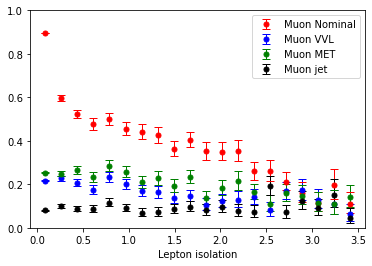

In [13]:
# now we plot trigger efficiency as function of ht
num_nom = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal"}]
num_vvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"vvl"}]
num_met = hists["jet"][{"region":"numerator","channel":"mu","trigger":"met"}]
num_jet = hists["jet"][{"region":"numerator","channel":"mu","trigger":"jet"}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nom/den, 
             yerr=get_yerr(num_nom,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal",         
)
hep.histplot(num_vvl/den, 
             yerr=get_yerr(num_vvl,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon VVL",         
)
hep.histplot(num_met/den, 
             yerr=get_yerr(num_met,den),
             ax = ax,
             histtype='errorbar', color='green', capsize=4, elinewidth=1, label="Muon MET",         
)
hep.histplot(num_jet/den, 
             yerr=get_yerr(num_jet,den),
             ax = ax,
             histtype='errorbar', color='black', capsize=4, elinewidth=1, label="Muon jet",         
)

ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/lepiso.pdf');

## Plotting distribution

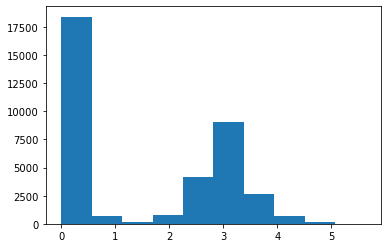

In [14]:
### plotting deltaR distribution
plt.hist(deltaR);

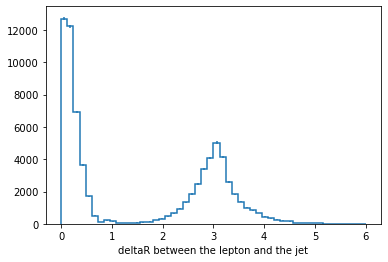

In [15]:
### plotting deltaR distribution
deltaR_axis = hist2.axis.Regular(50,0,6, name='deltaR', label=r'deltaR between the lepton and the jet')

hists = hist2.Hist(
                deltaR_axis,
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
hists.fill(deltaR)
hep.histplot(hists.fill(deltaR));

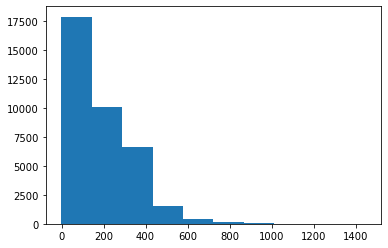

In [16]:
### plotting deltaR distribution
plt.hist(higgspt);

### Making OR

In [17]:
# now we can make histograms for higgspt, jetpt, leptonpt
import hist as hist2
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)

hpt_axis = hist2.axis.Regular(25, 100, 700, name='higgspt', label=r'matched H $p_T$ [GeV]')
jetpt_axis = hist2.axis.Regular(25, 200, 700, name='jetpt', label=r'Jet $p_T$ [GeV]')
leppt_axis = hist2.axis.Regular(25, 10, 400, name='leppt', label=r'Lepton $p_T$ [GeV]')

hists = {}
hists["jet"] = hist2.Hist(
                channel_cat,
                region_cat,
                trigger_cat,
                hpt_axis,
                jetpt_axis,
                leppt_axis,
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
higgspt = skimmed_events_mu["higgspt"]
jetpt = skimmed_events_mu["fj_pt"]
leppt = skimmed_events_mu["lep_pt"]

hists["jet"].fill(
    channel="mu",
    region="denominator",
    trigger="all",
    higgspt=higgspt,
    jetpt=jetpt,
    leppt=leppt,
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="nominal+vvl",
    higgspt=higgspt[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"]],
    jetpt=jetpt[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"]],
    leppt=leppt[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"]],
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="nominal+vvl+jet",
    higgspt=higgspt[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
    jetpt=jetpt[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
    leppt=leppt[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
)

hists["jet"]

Hist(
  StrCategory(['mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  StrCategory(['all', 'nominal+vvl', 'nominal+vvl+jet'], growth=True, name='trigger', label='trigger'),
  Regular(25, 100, 700, name='higgspt', label='matched H $p_T$ [GeV]'),
  Regular(25, 200, 700, name='jetpt', label='Jet $p_T$ [GeV]'),
  Regular(25, 10, 400, name='leppt', label='Lepton $p_T$ [GeV]'),
  storage=Double()) # Sum: 51691.0 (99295.0 with flow)

/tmp/ipykernel_174/2139677317.py:11: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())
/tmp/ipykernel_174/2139677317.py:11: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())


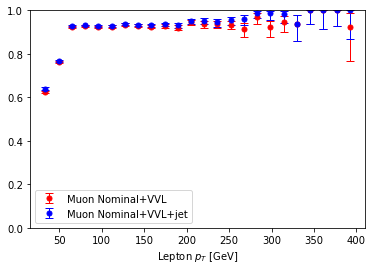

In [18]:
# now we plot trigger efficiency as function of leptonpt
num_nomvvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl", 'jetpt':sum, 'higgspt':sum}]
num_most = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl+jet", 'jetpt':sum, 'higgspt':sum}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum, 'jetpt':sum, 'higgspt':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nomvvl/den, 
             yerr=get_yerr(num_nomvvl,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal+VVL",         
)
hep.histplot(num_most/den, 
             yerr=get_yerr(num_most,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon Nominal+VVL+jet",         
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/most/leppt.pdf');

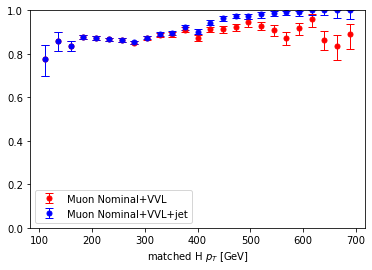

In [19]:
# now we plot trigger efficiency as function of higgspt
num_nomvvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl", 'leppt':sum, 'jetpt':sum}]
num_most = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl+jet", 'leppt':sum, 'jetpt':sum}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum, 'leppt':sum, 'jetpt':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nomvvl/den, 
             yerr=get_yerr(num_nomvvl,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal+VVL",         
)
hep.histplot(num_most/den, 
             yerr=get_yerr(num_most,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon Nominal+VVL+jet",         
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/most/higgspt.pdf');

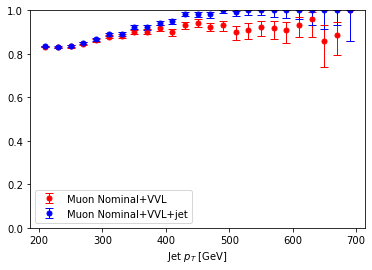

In [20]:
# now we plot trigger efficiency as function of jetpt
num_nomvvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl", 'higgspt':sum, 'leppt':sum}]
num_most = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl+jet", 'higgspt':sum, 'leppt':sum}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum, 'higgspt':sum, 'leppt':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nomvvl/den, 
             yerr=get_yerr(num_nomvvl,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal+VVL",         
)
hep.histplot(num_most/den, 
             yerr=get_yerr(num_most,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon Nominal+VVL+jet",         
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/most/jetpt.pdf');

In [21]:
# now we can make histograms for deltaR and HT
import hist as hist2
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)

deltaR_axis = hist2.axis.Regular(20, 0, 1.5, name='deltaR', label=r'deltaR')
ht_axis = hist2.axis.Regular(20,180, 1500, name='ht', label=r'HT [GeV]')
lepiso_axis = hist2.axis.Regular(20, 0, 3.5, name='lepiso', label=r'Lepton isolation')

hists = {}
hists["jet"] = hist2.Hist(
                channel_cat,
                region_cat,
                trigger_cat,
                deltaR_axis,
                ht_axis,
                lepiso_axis
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
deltaR = skimmed_events_mu["fj_lep_dR"]
ht = skimmed_events_mu["ht"]
lepiso = skimmed_events_mu["lep_isolation"]

hists["jet"].fill(
    channel="mu",
    region="denominator",
    trigger="all",
    deltaR=deltaR,
    ht=ht,
    lepiso=lepiso
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="nominal+vvl",
    deltaR=deltaR[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"]],
    ht=ht[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"]],
    lepiso=lepiso[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"]],
)
hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="nominal+vvl+jet",
    deltaR=deltaR[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
    ht=ht[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
    lepiso=lepiso[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
)

hists["jet"].fill(
    channel="mu",
    region="numerator",
    trigger="nominal+vvl+jet+photon",
    deltaR=deltaR[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
    ht=ht[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
    lepiso=lepiso[skimmed_events_mu["HLT_munominal"] | skimmed_events_mu["HLT_muvvl"] | skimmed_events_mu["HLT_jet"]],
)

hists["jet"]

Hist(
  StrCategory(['mu'], growth=True, name='channel', label='channel'),
  StrCategory(['numerator', 'denominator'], name='region', label='region'),
  StrCategory(['all', 'nominal+vvl', 'nominal+vvl+jet', 'nominal+vvl+jet+photon'], growth=True, name='trigger', label='trigger'),
  Regular(20, 0, 1.5, name='deltaR', label='deltaR'),
  Regular(20, 180, 1500, name='ht', label='HT [GeV]'),
  Regular(20, 0, 3.5, name='lepiso', label='Lepton isolation'),
  storage=Double()) # Sum: 68543.0 (130718.0 with flow)

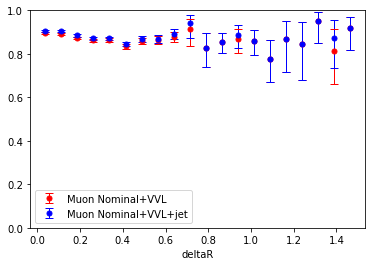

In [22]:
# now we plot trigger efficiency as function of deltaR
num_nomvvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl", 'ht':sum, 'lepiso':sum}]
num_most = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl+jet", 'ht':sum, 'lepiso':sum}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum, 'ht':sum, 'lepiso':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nomvvl/den, 
             yerr=get_yerr(num_nomvvl,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal+VVL",         
)
hep.histplot(num_most/den, 
             yerr=get_yerr(num_most,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon Nominal+VVL+jet",         
)
ax.set_ylim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/most/deltaR.pdf');

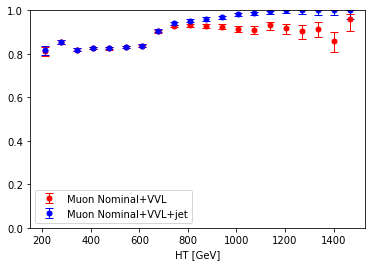

In [23]:
# now we plot trigger efficiency as function of ht
num_nomvvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl", 'deltaR':sum, 'lepiso':sum}]
num_most = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl+jet", 'deltaR':sum, 'lepiso':sum}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum, 'deltaR':sum, 'lepiso':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nomvvl/den, 
             yerr=get_yerr(num_nomvvl,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal+VVL",         
)
hep.histplot(num_most/den, 
             yerr=get_yerr(num_most,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon Nominal+VVL+jet",         
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/most/ht.pdf');

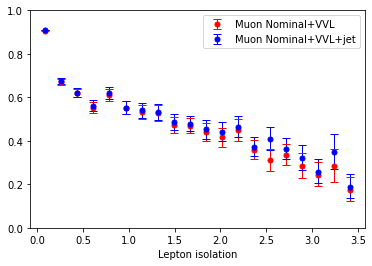

In [24]:
# now we plot trigger efficiency as function of lepiso
num_nomvvl = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl", 'deltaR':sum, 'ht':sum}]
num_most = hists["jet"][{"region":"numerator","channel":"mu","trigger":"nominal+vvl+jet", 'deltaR':sum, 'ht':sum}]

den = hists["jet"][{"region":"denominator","channel":"mu","trigger":sum, 'deltaR':sum, 'ht':sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num_nomvvl/den, 
             yerr=get_yerr(num_nomvvl,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Muon Nominal+VVL",         
)
hep.histplot(num_most/den, 
             yerr=get_yerr(num_most,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Muon Nominal+VVL+jet",         
)
ax.set_ylim(0,1)
ax.legend()
plt.savefig('plots/mu_triggers/most/lepiso.pdf');